## Signal Processing Task

This report investigates the application of classical filtering schemes in detecting Pinch hold, using measurements recorded from IMU and PPG sensors within smartwatches. More specifically, we are interested in understanding whether classical signal processing tools are capable of detecting timestamps corresponding to the rising edge of the label stream, serving as the truth ground for pinch hold initiation and termination.  We initially conducted an exploratory analysis using the IMU and PPG measurements provided. Performing frequency analysis, we observed that how different frequencies within the signals affect their behavior and observed that passing signals from IMU through a high pass filter (filtering lower frequencies), resulted in a very interesting behavior. More specifically, the filtered IMU signals exhibited strong peaks near the rising edges of label stream. Our findings strong peaks in highpass filtered IMU signals could be potential indicators of the rising edges of label stream. However, it is important to acknowledge the presence of a considerable number of false negatives, as well as, a much smaller proportion of false positives and strong peaks near the falling edges too. This indicates the need for a meticulous frequency analysis and the design of specialized filters that meet the requirements for more accurate detection of rising edges in the label stream. These improvements are essential for accurate identification of timestamps corresponding to Pinchholds.



## Loading Libraries



In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter
from scipy.signal import filtfilt
from scipy.signal import find_peaks as fp
from scipy.signal import decimate
from scipy import signal

FNAME = "data/{}_d32dd_01.npy"

## Defining Functions

In [12]:

# highpass, lowpass and bandpass butter filter
def butter_filter(signal, fc, fs, order, filter_type='highpass'):

    if filter_type == 'highpass':
        cutoff = fc / (0.5 * fs)
        b, a = butter(order, cutoff, btype='highpass', analog=False)
    elif filter_type == 'bandpass':
        cutoff_low = fc[0] / (0.5 * fs)
        cutoff_high = fc[1] / (0.5 * fs)
        b, a = butter(order, [cutoff_low, cutoff_high], btype='bandpass', analog=False)
    elif filter_type == 'lowpass':
        cutoff = fc / (0.5 * fs)
        b, a = butter(order, cutoff, btype='low', analog=False)
    else:    
        raise ValueError("Invalid filter. Use 'highpass', 'lowpass' or 'highpass'.")

    y = filtfilt(b, a, signal)
    return y

# window functions which select a section of input data by providing the starting point, length of the window and time sequence 
def mask_window (time_start, win_len, time_seq, measure_seq):

    time_end = time_start + win_len
    mask = np.logical_and(time_seq >= time_start, time_seq < time_end)

    if (measure_seq.ndim < 2):
        window_measure_seq = measure_seq[mask]
    else:
        window_measure_seq = measure_seq[mask,:]
  
    window_time_seq = time_seq[mask]

    return window_measure_seq ,window_time_seq


def find_correct_edges(vec1, vec2, threshold=0.01):
    
    vec1 = vec1[:, np.newaxis]
    vec2 = vec2[np.newaxis, :]
    absolute_diff = np.abs(vec1 - vec2)

    pos_flag = np.any(absolute_diff < threshold, axis=0)
    indices_vec1 = np.where(pos_flag)[0]


    return pos_flag,indices_vec1

# This functions finds that each element in vec2 which falls within the threshold distance of an element in vec1 and records the index of corresponding element in vec1
def find_matching_indices(vec1, vec2, threshold=0.01):
    matching_indices = np.full(len(vec2), -1, dtype=int)  # No Match is represented by -1
    
    for i, val in enumerate(vec2):
        differences = np.abs(vec1 - val)
        close_indices = np.where(differences < threshold)[0]
        
        if len(close_indices) > 0:
            matching_indices[i] = close_indices[0]  # Record the index of the first match
    
    return matching_indices

# This functions checks the that if two values in vec_flag are the same, it sets the one whose magnitude in vec_flag (magnitude of corresponding index) is smaller to -1
def pick_largest_magnitude(vec_mag, vec_flag):
    max_magnitudes = {}  # Dictionary to store maximum magnitudes for each unique non-negative integer
    
    for i, flag in enumerate(vec_flag):
        if flag != -1:
            # If the flag is not -1, update the maximum magnitude for this integer
            if flag not in max_magnitudes or vec_mag[i] > vec_mag[max_magnitudes[flag]]:
                max_magnitudes[flag] = i
                
    # Assign -1 to elements that are not selected
    for flag, max_magnitude_index in max_magnitudes.items():
        for i, val in enumerate(vec_flag):
            if val == flag and i != max_magnitude_index:
                vec_flag[i] = -1
    
    return vec_flag

 
def match_values(vec1, vec2):
    # Initialize result vectors
    matched_values = np.full_like(vec1, -1)
    former_locations = np.full_like(vec1, -1)

    # Iterate over elements of vec1
    for i, val in enumerate(vec1):
      
        matching_indices = np.where(vec2 == val)[0]

        # If there are matching indices, update matched_values and former_locations
        if len(matching_indices) > 0:
            matched_values[i] = vec2[matching_indices[0]]  
            former_locations[i] = matching_indices[0]  

    return matched_values, former_locations



def count_rising_edges(signal):
    num_pulses = 0
    rising_edges_loc = []

    # Iterate over the signal
    for i in range(1, len(signal)):
        # Check for rising edge
        if signal[i] == 1 and signal[i - 1] == 0:
            num_pulses += 1
            rising_edges_loc.append(i)

    return num_pulses, rising_edges_loc

# ploting labels over the given plot
def plot_lab(ax_):
    ax_.fill_between(
        lbl_millis, lbl, label="label", color="gray", alpha=0.2, step="post"
    )
    ax_.set_yticks([])
    ax_.spines[["top", "right"]].set_visible(False)
    ax_.legend()
    
# ploting labels over the given window
def plot_lab_window(ax_, window_lbl_millis, window_lbl ):
    #window_lbl_millis = np.squeeze(window_lbl_millis)
    ax_.fill_between(
        window_lbl_millis, window_lbl, label="label", color="gray", alpha=0.2, step="post"
    )
    ax_.set_yticks([])
    ax_.spines[["top", "right"]].set_visible(False)
    ax_.legend()

# This function finds the location of timestamps in IMU measurements which match the rising edges of the label stream
def rising_edges_identification(window_lbl, window_lbl_millis, window_imu_millis, window_gyro, window_acc, peaks_acc, peaks_gyro, threshold):

    num_rising_edges, rising_edges_loc  = count_rising_edges(window_lbl)
  

    # Find the 
    match_indices_acc= find_matching_indices(window_lbl_millis[rising_edges_loc], window_imu_millis[peaks_acc], threshold=0.02)
    match_indices_mod_acc=pick_largest_magnitude(window_acc[peaks_acc], match_indices_acc)
   


    match_indices_gyro= find_matching_indices(window_lbl_millis[rising_edges_loc], window_imu_millis[peaks_gyro], threshold=0.02) # (with which index in lbl_millis matches and of the same size as identified peaks)
    match_indices_mod_gyro=pick_largest_magnitude(window_gyro[peaks_gyro], match_indices_gyro)


   #    Fusion of rising edge detection results from gyroscope and accelerometer

    flag_sort_gyro,loc_gyro=match_values( range(len(rising_edges_loc)),match_indices_mod_gyro) # flag_sort_gyro of the same size the number of rising edges
    flag_sort_acc,loc_acc=match_values( range(len(rising_edges_loc)),match_indices_mod_acc)
    peaks_identified = np.zeros(len(flag_sort_acc))


    temp_acc=window_imu_millis[peaks_acc]
    temp_gyro=window_imu_millis[peaks_gyro]
    for i,val in enumerate(flag_sort_gyro):
        if flag_sort_gyro[i]==flag_sort_acc[i] and flag_sort_gyro[i] != -1:
            peaks_identified[i]=(temp_gyro[loc_gyro[i]]+temp_acc[loc_acc[i]])/2
        elif flag_sort_gyro[i] ==-1 and flag_sort_acc[i] !=-1:
            peaks_identified[i]=temp_acc[loc_acc[i]]
        elif flag_sort_acc[i] ==-1 and flag_sort_gyro[i] !=-1:
            peaks_identified[i]=temp_gyro[loc_gyro[i]]
        else:
            peaks_identified[i]= -1 

                
    return peaks_identified



We now start by visualizing the signals from IMU and PPG sensors. 

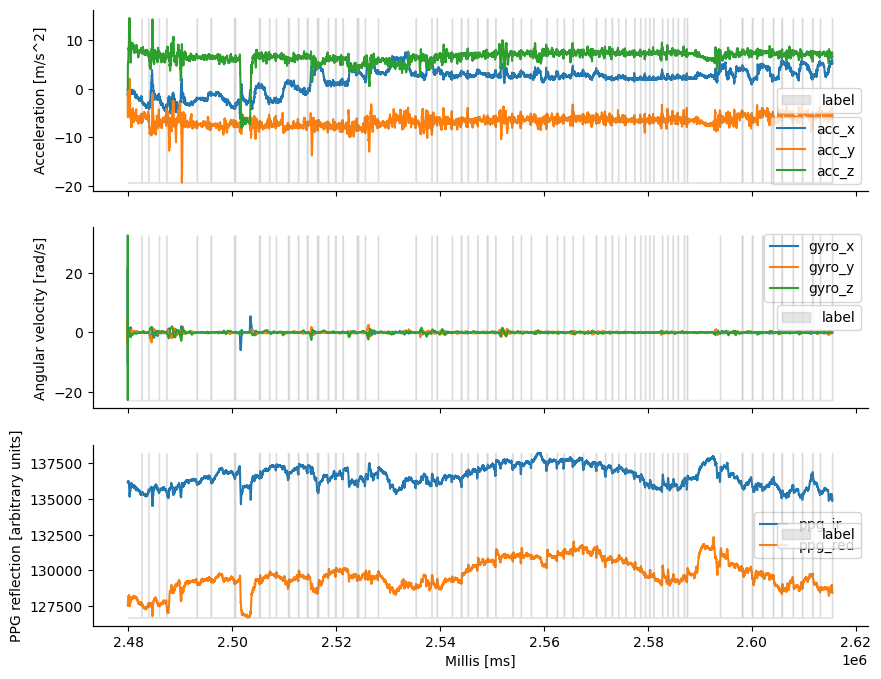

In [13]:
if __name__ == "__main__":
    imu = np.load(FNAME.format("imu"))

    imu_millis = imu[:, 0]
    acc = imu[:, 1:4]
    gyro = imu[:, 4:]

    ppg = np.load(FNAME.format("ppg"))
    ppg_millis = ppg[:, 0]
    ppg = ppg[:, 1:]

    lbl = np.load(FNAME.format("label"))
    lbl_millis = lbl[:, 0]
    lbl = lbl[:, 1]

    _, axarr = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
    axarr[0].plot(imu_millis, acc, label=["acc_x", "acc_y", "acc_z"])
    plot_lab(axarr[0].twinx())

    axarr[1].plot(imu_millis, gyro, label=["gyro_x", "gyro_y", "gyro_z"])
    plot_lab(axarr[1].twinx())

    axarr[2].plot(ppg_millis, ppg, label=["ppg_ir", "ppg_red"])
    plot_lab(axarr[2].twinx())

    for ax in axarr:
        ax.spines[["top", "right"]].set_visible(False)
        ax.legend()

    axarr[0].set_ylabel("Acceleration [m/s^2]")
    axarr[1].set_ylabel("Angular velocity [rad/s]")
    axarr[2].set_ylabel("PPG reflection [arbitrary units]")
    axarr[2].set_xlabel("Millis [ms]")


We first probe the entire IMU and PPG measurements alongside the label stream. However, it seems difficult to find any correlation pattern between the rising edges of label streams and the given measurements. At this point, we decided to focus on a smaller window of the sensors measurements and our objective is to see if any clear pattern linking them with the rising edges of label streams.

Text(0.5, 0, 'Millis [ms]')

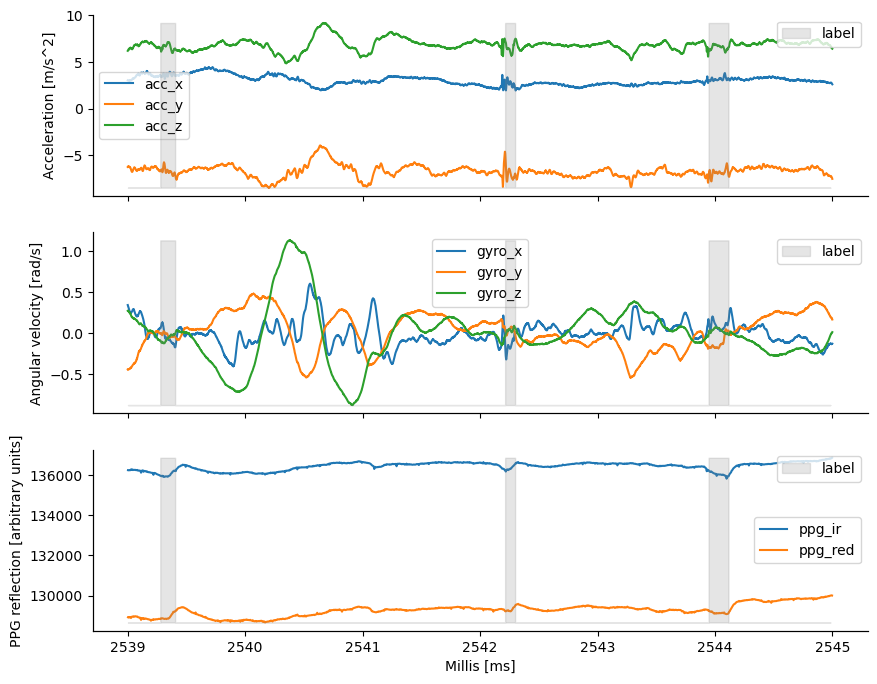

In [14]:
    # Setting the starting time of the window and its width
    time_start = 2539
    win_len = 6

    # Selecting the specified window of gyroscope and accelerometer signals from IMU sensor
    window_acc , _ = mask_window (time_start, win_len, imu_millis/1e3 , acc)
    window_gyro , window_imu_millis = mask_window (time_start, win_len, imu_millis/1e3 , gyro)

    # Selecting the specified window of ppg signals from PPG sensor
    window_ppg , window_ppg_millis = mask_window (time_start, win_len, ppg_millis/1e3 , ppg)
    
    # Selecting the specified window of label streams
    window_lbl , window_lbl_millis = mask_window (time_start, win_len, lbl_millis/1e3 , lbl)

    _, axarr_window = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
    axarr_window[0].plot(window_imu_millis, window_acc, label=["acc_x", "acc_y", "acc_z"])
    plot_lab_window(axarr_window[0].twinx(), window_lbl_millis, window_lbl)

    axarr_window[1].plot(window_imu_millis, window_gyro, label=["gyro_x", "gyro_y", "gyro_z"])
    plot_lab_window(axarr_window[1].twinx(), window_lbl_millis, window_lbl)

    axarr_window[2].plot(window_ppg_millis, window_ppg, label=["ppg_ir", "ppg_red"])
    plot_lab_window(axarr_window[2].twinx(), window_lbl_millis, window_lbl)

    for ax in axarr_window:
        ax.spines[["top", "right"]].set_visible(False)
        ax.legend()

    axarr_window[0].set_ylabel("Acceleration [m/s^2]")
    axarr_window[1].set_ylabel("Angular velocity [rad/s]")
    axarr_window[2].set_ylabel("PPG reflection [arbitrary units]")
    axarr_window[2].set_xlabel("Millis [ms]")

From the above plots, we gain a more localized insight into the iterplay between different sensor measurements and label stream. However, we do not observe any obvious pattern. As our next step, we resort to classical tools from signal processing and conduct a frequency analysis. We compute the discrete fourier transform (DFT) of IMU and PPG measurements along each dimension. Subsequently, we plot the power spectrum of each signal to analyze how signals power is distributed across different frequencies.


Text(0.5, 0, 'frequency [Hz]')

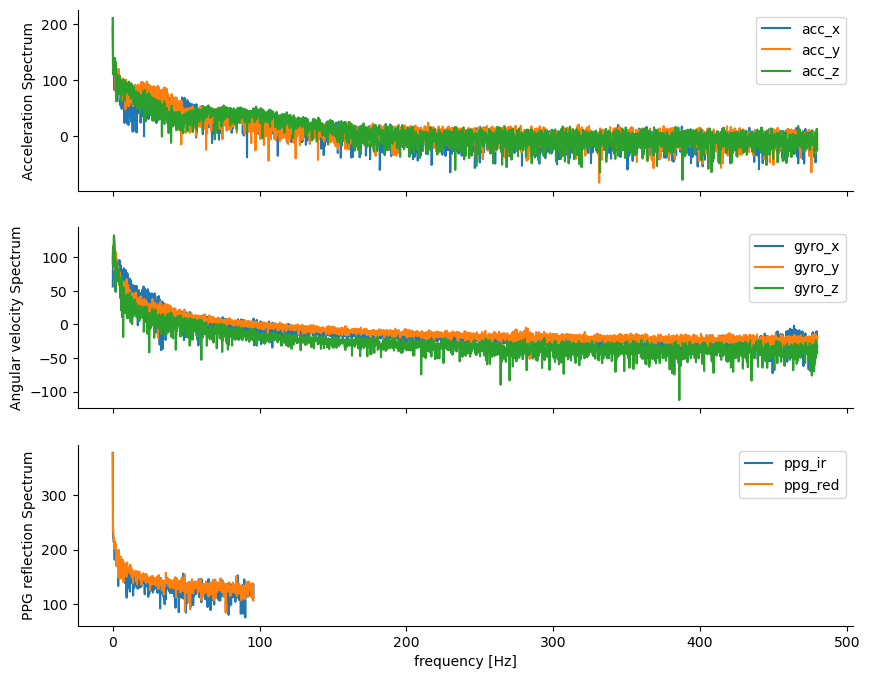

In [15]:
    
    # setting the sampling frequencies as specified in the task
    fs_imu = 960 # (Hz)
    fs_ppg = 192 # (Hz)

    # Taking the DFT and plotting the power spectrum ----- Accelerometers
    dft_acc_x = np.fft.fft(window_acc[:,0])
    dft_acc_y = np.fft.fft(window_acc[:,1])
    dft_acc_z = np.fft.fft(window_acc[:,2])


    dft_acc = np.vstack((dft_acc_x,dft_acc_y,dft_acc_z)).T
    dft_f_acc = np.fft.fftfreq(n=len(window_acc[:,0]), d = 1.0/fs_imu)


    # Taking the DFT and plotting the power spectrum ----- Gyroscopes
    dft_gyro_x = np.fft.fft(window_gyro[:,0])
    dft_gyro_y = np.fft.fft(window_gyro[:,1])
    dft_gyro_z = np.fft.fft(window_gyro[:,2])
   

    dft_gyro = np.vstack((dft_gyro_x,dft_gyro_y,dft_gyro_z)).T
    dft_f_gyro = np.fft.fftfreq(n=len(window_gyro[:,0]), d = 1.0/fs_imu)


    # Taking the DFT and plotting the power spectrum ----- PPG
    dft_ppg_ir = np.fft.fft(window_ppg[:,0])
    dft_ppg_red = np.fft.fft(window_ppg[:,1])


    dft_ppg = np.vstack((dft_ppg_ir,dft_ppg_red)).T
    dft_f_ppg = np.fft.fftfreq(n=len(window_ppg[:,0]), d = 1.0/fs_ppg)

    # Plotting the power spectrum

    _, axarr = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
    axarr[0].plot(dft_f_acc[:len(dft_acc)//2],20*np.log(np.abs(dft_acc[:len( dft_acc)//2,:])), label=["acc_x", "acc_y", "acc_z"]) 
    axarr[1].plot(dft_f_gyro[:len(dft_gyro)//2],20*np.log(np.abs(dft_gyro[:len( dft_gyro)//2,:])), label=["gyro_x", "gyro_y", "gyro_z"])
    axarr[2].plot(dft_f_ppg[:len(dft_ppg)//2],20*np.log(np.abs(dft_ppg[:len( dft_ppg)//2,:])), label=["ppg_ir", "ppg_red"])

    for ax in axarr:
        ax.spines[["top", "right"]].set_visible(False)
        ax.legend()

    axarr[0].set_ylabel("Acceleration Spectrum")
    axarr[1].set_ylabel("Angular velocity Spectrum")
    axarr[2].set_ylabel("PPG reflection Spectrum")
    axarr[2].set_xlabel("frequency [Hz]")


From the above plots, it follows that the bulk of the energy is concentrated in lower frequencies. Further, we pass our IMU and PPG measurements through a low pass Butterworth filter with a cuttoff frequency of 10 Hz. As a result, we observe that the there are less of fluctuations while preserving the overall signal trend and still no notable correlation between the behavior of the provided measurements and the label stream at the rising edges is seen. Therefore, one should search for relevant information at higher frequencies. To do so, we will zero out all frequencies below 30 Hz in the DFT sequence. We will then plot the power spectrum, observing that there exists high energy components around midrange frequencies exceeding 30 Hz. Except for PPG, the power is distributed rather even across the entire spectrum. 

Text(0.5, 0, 'Millis [ms]')

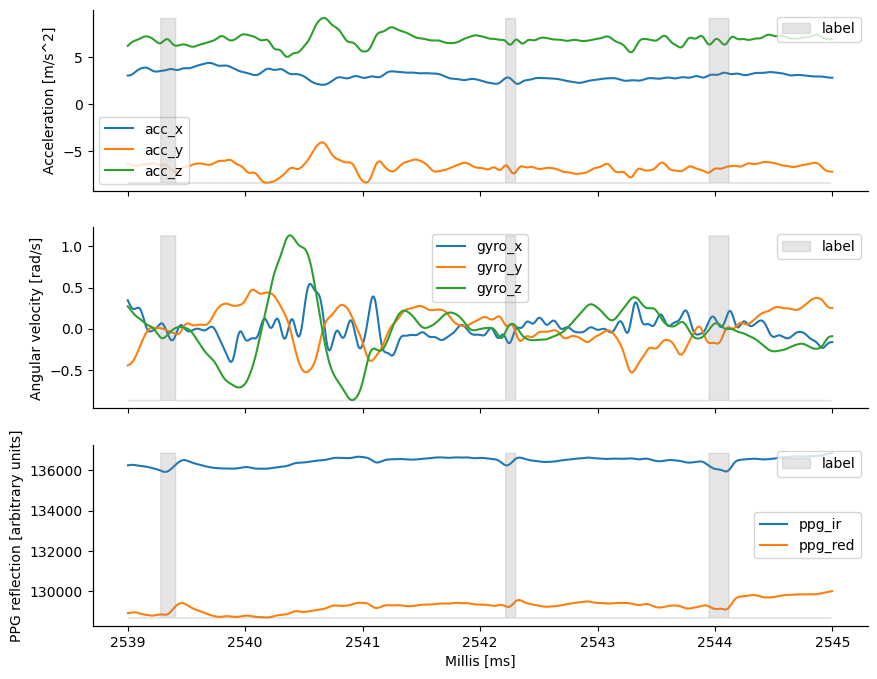

In [16]:
    # setting the cutoff frequency for low pass filters
    order = 5 #(filter order)
    fc_l_acc = 10
    fc_l_gyro = 10
    fc_l_ppg = 10

    
    # low pass filtering of accelerometer measurements
    filtered_acc_x = butter_filter(window_acc[:,0], fc_l_acc, fs_imu, order, filter_type='lowpass')
    filtered_acc_y = butter_filter(window_acc[:,1], fc_l_acc, fs_imu, order, filter_type='lowpass')
    filtered_acc_z = butter_filter(window_acc[:,2], fc_l_acc, fs_imu, order, filter_type='lowpass')
    filtered_acc = np.vstack((filtered_acc_x,filtered_acc_y,filtered_acc_z)).T

    # low pass filtering of gyroscope measurements
    filtered_gyro_x = butter_filter(window_gyro[:,0], fc_l_gyro, fs_imu, order, filter_type='lowpass')
    filtered_gyro_y = butter_filter(window_gyro[:,1], fc_l_gyro, fs_imu, order, filter_type='lowpass')
    filtered_gyro_z = butter_filter(window_gyro[:,2], fc_l_gyro, fs_imu, order, filter_type='lowpass')
    filtered_gyro = np.vstack((filtered_gyro_x,filtered_gyro_y,filtered_gyro_z)).T

    # low pass filtering of ppg measurements
    filtered_ppg_ir = butter_filter(window_ppg[:,0], fc_l_ppg, fs_ppg, order, filter_type='lowpass')
    filtered_ppg_red = butter_filter(window_ppg[:,1], fc_l_ppg, fs_ppg, order, filter_type='lowpass')
    filtered_ppg = np.vstack((filtered_ppg_ir,filtered_ppg_red)).T

    # plotting the filtered measurements within the given window
    _, axarr_window = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
    axarr_window[0].plot(window_imu_millis, filtered_acc, label=["acc_x", "acc_y", "acc_z"])
    plot_lab_window(axarr_window[0].twinx(), window_lbl_millis, window_lbl)
    
    axarr_window[1].plot(window_imu_millis, filtered_gyro, label=["gyro_x", "gyro_y", "gyro_z"])
    plot_lab_window(axarr_window[1].twinx(), window_lbl_millis, window_lbl)

    axarr_window[2].plot(window_ppg_millis, filtered_ppg, label=["ppg_ir", "ppg_red"])
    plot_lab_window(axarr_window[2].twinx(), window_lbl_millis, window_lbl)

    for ax in axarr_window:
        ax.spines[["top", "right"]].set_visible(False)
        ax.legend()

    axarr_window[0].set_ylabel("Acceleration [m/s^2]")
    axarr_window[1].set_ylabel("Angular velocity [rad/s]")
    axarr_window[2].set_ylabel("PPG reflection [arbitrary units]")
    axarr_window[2].set_xlabel("Millis [ms]")

/tmp/ipykernel_28886/1214377009.py:48: RuntimeWarning: divide by zero encountered in log
  axarr[0].plot(dft_f_acc[:len(modified_dft_acc)//2],20*np.log(np.abs(modified_dft_acc[:len( modified_dft_acc)//2,:])), label=["acc_x", "acc_y", "acc_z"])
/tmp/ipykernel_28886/1214377009.py:49: RuntimeWarning: divide by zero encountered in log
  axarr[1].plot(dft_f_gyro[:len(modified_dft_gyro)//2],20*np.log(np.abs(modified_dft_gyro[:len( modified_dft_gyro)//2,:])), label=["gyro_x", "gyro_y", "gyro_z"])
/tmp/ipykernel_28886/1214377009.py:50: RuntimeWarning: divide by zero encountered in log
  axarr[2].plot(dft_f_ppg[:len(modified_dft_ppg)//2],20*np.log(np.abs(modified_dft_ppg[:len( modified_dft_ppg)//2,:])), label=["ppg_ir", "ppg_red"])


Text(0.5, 0, 'frequency [Hz]')

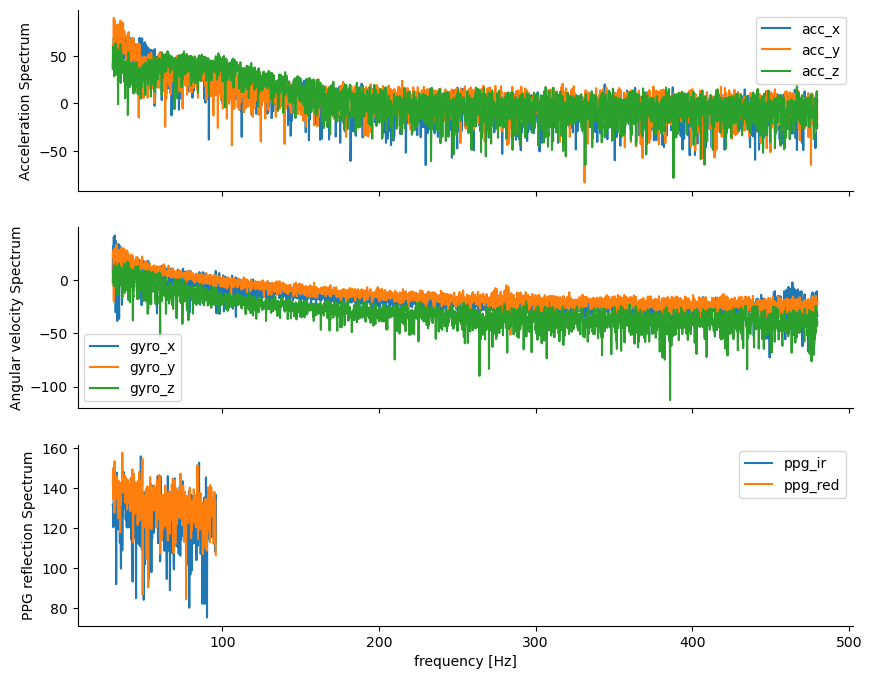

In [17]:
    # Setting frequency component below 30 hz to zero    
    f_zero=30 # frequencies below 30 Hz are set to zero

    ind_above_cutoff_acc_x = np.where(dft_f_acc < f_zero)[0]
    modified_dft_acc_x = dft_acc_x.copy()
    modified_dft_acc_x[ind_above_cutoff_acc_x] = 0.0 + 0.0j

    ind_above_cutoff_acc_y= np.where(dft_f_acc < f_zero)[0]
    modified_dft_acc_y= dft_acc_y.copy()
    modified_dft_acc_y[ind_above_cutoff_acc_y] = 0.0 + 0.0j

    ind_above_cutoff_acc_z = np.where(dft_f_acc < f_zero)[0]
    modified_dft_acc_z = dft_acc_z.copy()
    modified_dft_acc_z[ind_above_cutoff_acc_z] = 0.0 + 0.0j

    modified_dft_acc = np.vstack((modified_dft_acc_x,modified_dft_acc_y,modified_dft_acc_z)).T


    ind_above_cutoff_gyro_x = np.where(dft_f_gyro < f_zero)[0]
    modified_dft_gyro_x = dft_gyro_x.copy()
    modified_dft_gyro_x[ind_above_cutoff_gyro_x] = 0.0 + 0.0j

    ind_above_cutoff_gyro_y= np.where(dft_f_gyro < f_zero)[0]
    modified_dft_gyro_y= dft_gyro_y.copy()
    modified_dft_gyro_y[ind_above_cutoff_gyro_y] = 0.0 + 0.0j

    ind_above_cutoff_gyro_z = np.where(dft_f_gyro < f_zero)[0]
    modified_dft_gyro_z = dft_gyro_z.copy()
    modified_dft_gyro_z[ind_above_cutoff_gyro_z] = 0.0 + 0.0j

    modified_dft_gyro = np.vstack((modified_dft_gyro_x,modified_dft_gyro_y,modified_dft_gyro_z)).T


    ind_above_cutoff_ppg_ir = np.where(dft_f_ppg < f_zero)[0]
    modified_dft_ppg_ir = dft_ppg_ir.copy()
    modified_dft_ppg_ir[ind_above_cutoff_ppg_ir] = 0.0 + 0.0j

    ind_above_cutoff_ppg_red= np.where(dft_f_ppg < f_zero)[0]
    modified_dft_ppg_red= dft_ppg_red.copy()
    modified_dft_ppg_red[ind_above_cutoff_ppg_red] = 0.0 + 0.0j

    modified_dft_ppg = np.vstack((modified_dft_ppg_ir,modified_dft_ppg_red)).T


    # Plotting the power spectrum

    _, axarr = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
    axarr[0].plot(dft_f_acc[:len(modified_dft_acc)//2],20*np.log(np.abs(modified_dft_acc[:len( modified_dft_acc)//2,:])), label=["acc_x", "acc_y", "acc_z"]) 
    axarr[1].plot(dft_f_gyro[:len(modified_dft_gyro)//2],20*np.log(np.abs(modified_dft_gyro[:len( modified_dft_gyro)//2,:])), label=["gyro_x", "gyro_y", "gyro_z"])
    axarr[2].plot(dft_f_ppg[:len(modified_dft_ppg)//2],20*np.log(np.abs(modified_dft_ppg[:len( modified_dft_ppg)//2,:])), label=["ppg_ir", "ppg_red"])

    for ax in axarr:
        ax.spines[["top", "right"]].set_visible(False)
        ax.legend()

    axarr[0].set_ylabel("Acceleration Spectrum")
    axarr[1].set_ylabel("Angular velocity Spectrum")
    axarr[2].set_ylabel("PPG reflection Spectrum")
    axarr[2].set_xlabel("frequency [Hz]")

<!-- Next, we will reconstruct the signal using IDFT and plot them gainst label streams. Surprisingly, we observe an interesting pattern in the reconstructed IMU and PPG signals near the rising edges of label streams, particularly in IMU streams. -->

Building up on ur findings from the frequency analysis, we hypothesize that passing our IMU and PPG measurements through a high pass filter could result in something more relevant to the problem in hand. We chose the Butterworth filter, exhibiting no ripples in the passband, with an order of 5. In essence, the highpass filter attenuates or blocks the frequency content of the input signals (IMU and PPG measurements) for frequencies below the cutoff frequency while allowing frequencies higher than cutoff frequency to pass through.


 We have done several experiments over the choice of cutoff frequency and observed a surprising phenomenon. The filtered signals from IMU measurement succeed in detecting the majority of timestamps corresponding to the rising edges of label stream. We see strong peaks in the filtered signal near these point. This trend is preserved over a range of cutoff frequencies from around 40 to 70 Hz. Thus, we may set the cutoff frequency to be $40$ Hz. However, our analysis reveals instances where the filtered signals illustrate weak peaks near the rising edge of the label stream or conversely the filtered signals (IMU signals) show strong peaks near the falling edge of label stream. Although rare, there are timestamps, where the filtered signals (IMU signals) show strong peaks despite the absence of a corresponding rising edge in the label stream nearby. Additionally, we have not been able to identify any correspondence between the filtered PPG and the rising edges of label stream, but this could be attributed to the above power spectrum from preceding plots.









/tmp/ipykernel_28886/4092294971.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Text(0.5, 0, 'Millis [ms]')

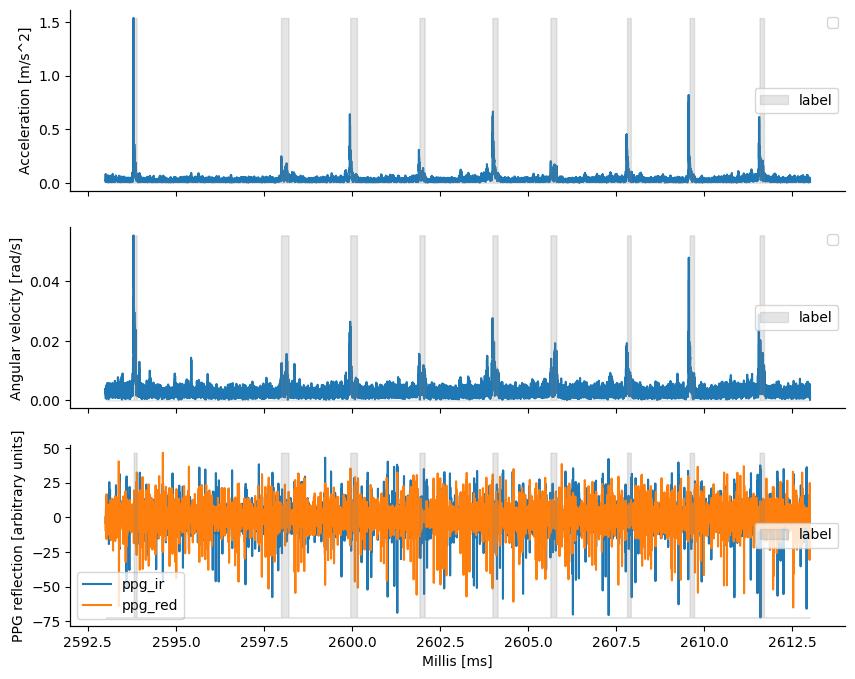

In [22]:
    # setting the cutoff freuency of highpass filters
    fc_h_acc = 40
    fc_h_gyro = 40
    fc_h_ppg = 40      


    
    # high pass filtering of accelerometer measurements
    filtered_acc_x = butter_filter(window_acc[:,0], fc_h_acc, fs_imu, order, filter_type='highpass')
    filtered_acc_y = butter_filter(window_acc[:,1], fc_h_acc, fs_imu, order, filter_type='highpass')
    filtered_acc_z = butter_filter(window_acc[:,2], fc_h_acc, fs_imu, order, filter_type='highpass')
    filtered_acc = np.vstack((filtered_acc_x,filtered_acc_y,filtered_acc_z)).T

    # high pass filtering of gyroscope measurements
    filtered_gyro_x = butter_filter(window_gyro[:,0], fc_h_gyro, fs_imu, order, filter_type='highpass')
    filtered_gyro_y = butter_filter(window_gyro[:,1], fc_h_gyro, fs_imu, order, filter_type='highpass')
    filtered_gyro_z = butter_filter(window_gyro[:,2], fc_h_gyro, fs_imu, order, filter_type='highpass')
    filtered_gyro = np.vstack((filtered_gyro_x,filtered_gyro_y,filtered_gyro_z)).T

    # high pass filtering of ppg measurements
    filtered_ppg_ir = butter_filter(window_ppg[:,0], fc_h_ppg, fs_ppg, order, filter_type='highpass')
    filtered_ppg_red = butter_filter(window_ppg[:,1], fc_h_ppg, fs_ppg, order, filter_type='highpass')
    filtered_ppg = np.vstack((filtered_ppg_ir,filtered_ppg_red)).T

    #Plotting the high pass filtered measurements
    _, axarr_window = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
    axarr_window[0].plot(window_imu_millis, np.sqrt(np.sum(np.square(filtered_acc), axis=1)))
    plot_lab_window(axarr_window[0].twinx(), window_lbl_millis, window_lbl)
    
    axarr_window[1].plot(window_imu_millis,np.sqrt(np.sum(np.square(filtered_gyro), axis=1)))
    plot_lab_window(axarr_window[1].twinx(), window_lbl_millis, window_lbl)

    axarr_window[2].plot(window_ppg_millis, filtered_ppg, label=["ppg_ir", "ppg_red"])
    plot_lab_window(axarr_window[2].twinx(), window_lbl_millis, window_lbl)

    for ax in axarr_window:
        ax.spines[["top", "right"]].set_visible(False)
        ax.legend()

    axarr_window[0].set_ylabel("Acceleration [m/s^2]")
    axarr_window[1].set_ylabel("Angular velocity [rad/s]")
    axarr_window[2].set_ylabel("PPG reflection [arbitrary units]")
    axarr_window[2].set_xlabel("Millis [ms]")

In the above plot, the filtered signals exhibit weak peak near the rising for the first instance of rising edges of the label stream. Furthermore, the PPG possess a strong peak near the falling edge of second instance (Pinch hold).

/tmp/ipykernel_28886/1046886968.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Text(0.5, 0, 'Millis [ms]')

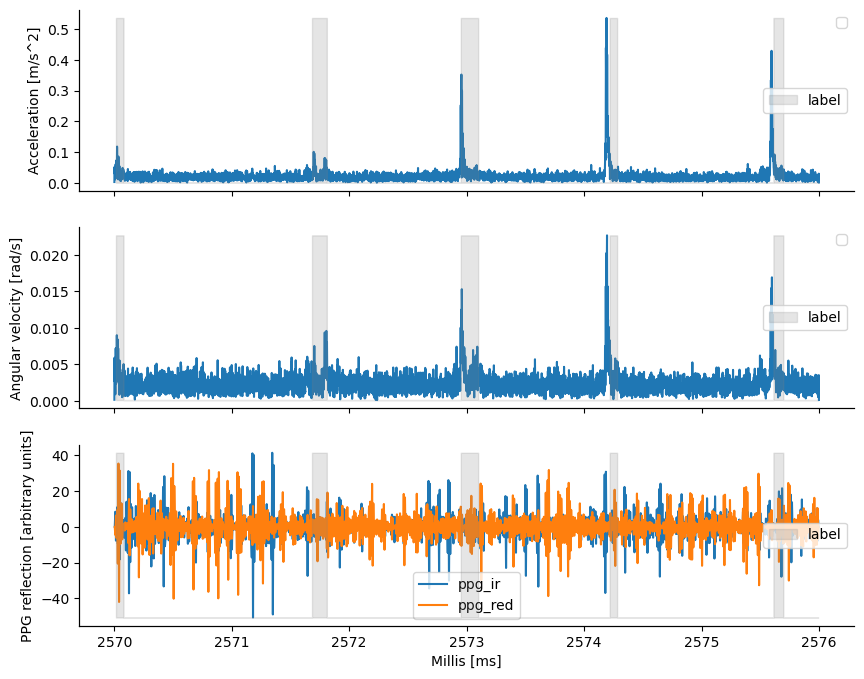

In [23]:
    # setting the cutoff frequency for highpass filteres
    fc_h_acc = 60
    fc_h_gyro = 60
    fc_h_ppg = 60

    # Setting the starting time of the window and its width
    time_start = 2570
    win_len = 6

    # Selecting the specified window of gyroscope and accelerometer signals from IMU sensor
    window_acc , _ = mask_window (time_start, win_len, imu_millis/1e3 , acc)
    window_gyro , window_imu_millis = mask_window (time_start, win_len, imu_millis/1e3 , gyro)

    # Selecting the specified window of ppg signals from PPG sensor
    window_ppg , window_ppg_millis = mask_window (time_start, win_len, ppg_millis/1e3 , ppg)
    
    # Selecting the specified window of label streams
    window_lbl , window_lbl_millis = mask_window (time_start, win_len, lbl_millis/1e3 , lbl)      

    
    # plotting the highpass filtered measurements
    filtered_acc_x = butter_filter(window_acc[:,0], fc_h_acc, fs_imu, order, filter_type='highpass')
    filtered_acc_y = butter_filter(window_acc[:,1], fc_h_acc, fs_imu, order, filter_type='highpass')
    filtered_acc_z = butter_filter(window_acc[:,2], fc_h_acc, fs_imu, order, filter_type='highpass')
    filtered_acc = np.vstack((filtered_acc_x,filtered_acc_y,filtered_acc_z)).T

    filtered_gyro_x = butter_filter(window_gyro[:,0], fc_h_gyro, fs_imu, order, filter_type='highpass')
    filtered_gyro_y = butter_filter(window_gyro[:,1], fc_h_gyro, fs_imu, order, filter_type='highpass')
    filtered_gyro_z = butter_filter(window_gyro[:,2], fc_h_gyro, fs_imu, order, filter_type='highpass')
    filtered_gyro = np.vstack((filtered_gyro_x,filtered_gyro_y,filtered_gyro_z)).T


    filtered_ppg_ir = butter_filter(window_ppg[:,0], fc_h_ppg, fs_ppg, order, filter_type='highpass')
    filtered_ppg_red = butter_filter(window_ppg[:,1], fc_h_ppg, fs_ppg, order, filter_type='highpass')
    filtered_ppg = np.vstack((filtered_ppg_ir,filtered_ppg_red)).T

    _, axarr_window = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
    axarr_window[0].plot(window_imu_millis, np.sqrt(np.sum(np.square(filtered_acc), axis=1)))
    plot_lab_window(axarr_window[0].twinx(), window_lbl_millis, window_lbl)
    
    axarr_window[1].plot(window_imu_millis,np.sqrt(np.sum(np.square(filtered_gyro), axis=1)))
    plot_lab_window(axarr_window[1].twinx(), window_lbl_millis, window_lbl)

    axarr_window[2].plot(window_ppg_millis, filtered_ppg, label=["ppg_ir", "ppg_red"])
    plot_lab_window(axarr_window[2].twinx(), window_lbl_millis, window_lbl)

    for ax in axarr_window:
        ax.spines[["top", "right"]].set_visible(False)
        ax.legend()

    axarr_window[0].set_ylabel("Acceleration [m/s^2]")
    axarr_window[1].set_ylabel("Angular velocity [rad/s]")
    axarr_window[2].set_ylabel("PPG reflection [arbitrary units]")
    axarr_window[2].set_xlabel("Millis [ms]")

In the above plot, the filtered signals exhibit weak peak near the rising for the first and second instances of rising edges of the label stream.

/tmp/ipykernel_28886/3358038132.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Text(0.5, 0, 'Millis [ms]')

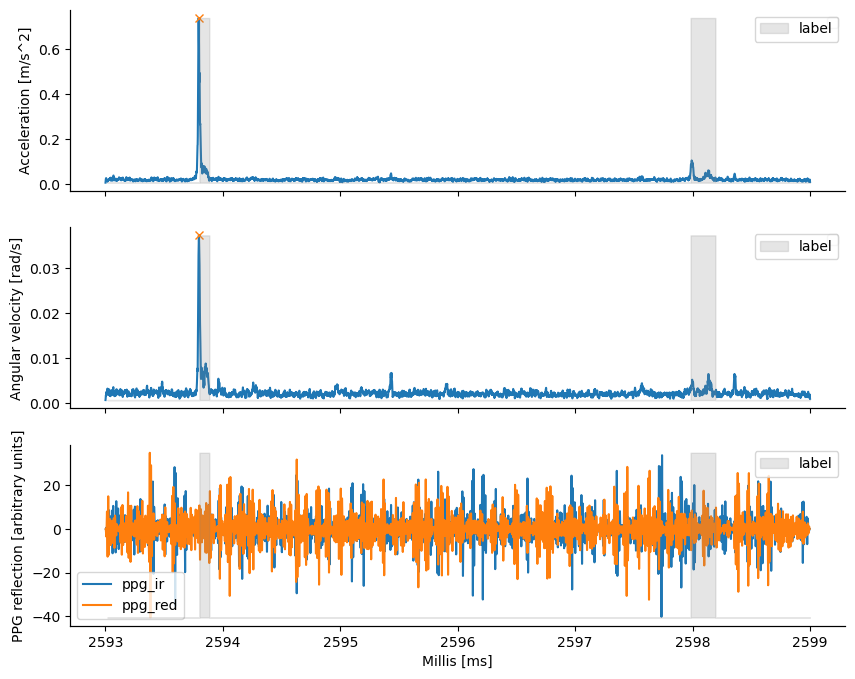

In [24]:
    # setting the cutoff frequency of high pass filters
    fc_h_acc = 60
    fc_h_gyro = 60
    fc_h_ppg = 60

    # Setting the starting time of the window and its width
    time_start = 2593
    win_len = 6
    window_size = 5
    padding = window_size // 2

    # Selecting the specified window of gyroscope and accelerometer signals from IMU sensor
    window_acc , _ = mask_window (time_start, win_len, imu_millis/1e3 , acc)
    window_gyro , window_imu_millis = mask_window (time_start, win_len, imu_millis/1e3 , gyro)

    # Selecting the specified window of ppg signals from PPG sensor
    window_ppg , window_ppg_millis = mask_window (time_start, win_len, ppg_millis/1e3 , ppg)
    
    # Selecting the specified window of label streams
    window_lbl , window_lbl_millis = mask_window (time_start, win_len, lbl_millis/1e3 , lbl)      

    
    # high pass filtering of accelerometer measurements followed by a moving average filter
    filtered_acc_x = butter_filter(window_acc[:,0], fc_h_acc, fs_imu, order, filter_type='highpass')
    filtered_acc_y = butter_filter(window_acc[:,1], fc_h_acc, fs_imu, order, filter_type='highpass')
    filtered_acc_z = butter_filter(window_acc[:,2], fc_h_acc, fs_imu, order, filter_type='highpass')
    filtered_acc = np.vstack((filtered_acc_x,filtered_acc_y,filtered_acc_z)).T
    filtered_acc = np.convolve(np.pad(np.sqrt(np.sum(np.square(filtered_acc), axis=1)),padding, mode='edge'), np.ones(window_size)/window_size, mode='valid')

    
    
    # Applying peak detection algorithm to our processed signal to find the location of strong peaks corresponding to rising edges of the label stream
    peak_finder_setting = {'height': 0.2, 'prominence': None, 'distance_factor': 0.02}
    peaks_acc, _ = fp(
            filtered_acc,
            height=peak_finder_setting['height'],
            prominence=peak_finder_setting['prominence'],
            distance= peak_finder_setting['distance_factor']*fs_imu
    )
    
    # high pass filtering of gyroscope measurements followed by a moving average filter
    filtered_gyro_x = butter_filter(window_gyro[:,0], fc_h_gyro, fs_imu, order, filter_type='highpass')
    filtered_gyro_y = butter_filter(window_gyro[:,1], fc_h_gyro, fs_imu, order, filter_type='highpass')
    filtered_gyro_z = butter_filter(window_gyro[:,2], fc_h_gyro, fs_imu, order, filter_type='highpass')
    filtered_gyro = np.vstack((filtered_gyro_x,filtered_gyro_y,filtered_gyro_z)).T
    filtered_gyro = np.convolve(np.pad(np.sqrt(np.sum(np.square(filtered_gyro), axis=1)),padding, mode='edge'), np.ones(window_size)/window_size, mode='valid')

    # Applying peak detection algorithm to our processed signal to find the location of strong peaks corresponding to rising edges of the label stream
    peak_finder_setting = {'height': 0.01, 'prominence': None, 'distance_factor': 0.02}
    peaks_gyro, _ = fp(
            filtered_gyro,
            height=peak_finder_setting['height'],
            prominence=peak_finder_setting['prominence'],
            distance= peak_finder_setting['distance_factor']*fs_imu
    )


    # high pass filtering of ppg measurements 
    filtered_ppg_ir = butter_filter(window_ppg[:,0], fc_h_ppg, fs_ppg, order, filter_type='highpass')
    filtered_ppg_red = butter_filter(window_ppg[:,1], fc_h_ppg, fs_ppg, order, filter_type='highpass')
    filtered_ppg = np.vstack((filtered_ppg_ir,filtered_ppg_red)).T

    # plotting the filtered signals along with results from peak detection algorithm, which are not the final results of rising edge detection   
    _, axarr_window = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
    #axarr_window[0].plot(window_imu_millis, np.sqrt(np.sum(np.square(filtered_acc), axis=1)))
    axarr_window[0].plot(window_imu_millis, filtered_acc)
    axarr_window[0].plot(window_imu_millis[peaks_acc], filtered_acc[peaks_acc], "x")
    plot_lab_window(axarr_window[0].twinx(), window_lbl_millis, window_lbl)
    
    #axarr_window[1].plot(window_imu_millis,np.sqrt(np.sum(np.square(filtered_gyro), axis=1)))
    axarr_window[1].plot(window_imu_millis, filtered_gyro)
    axarr_window[1].plot(window_imu_millis[peaks_gyro], filtered_gyro[peaks_gyro], "x")
    plot_lab_window(axarr_window[1].twinx(), window_lbl_millis, window_lbl)

    axarr_window[2].plot(window_ppg_millis, filtered_ppg, label=["ppg_ir", "ppg_red"])
    plot_lab_window(axarr_window[2].twinx(), window_lbl_millis, window_lbl)

    for ax in axarr_window:
        ax.spines[["top", "right"]].set_visible(False)
        ax.legend()

    axarr_window[0].set_ylabel("Acceleration [m/s^2]")
    axarr_window[1].set_ylabel("Angular velocity [rad/s]")
    axarr_window[2].set_ylabel("PPG reflection [arbitrary units]")
    axarr_window[2].set_xlabel("Millis [ms]")

In the above plot, the filtered signals exhibit weak peak near the rising for the first instance of rising edges of the label stream.

Note that in the above plots, we have plotted the magnitude of the filtered signals from IMU measurements, specifically from gryoscope and accelerometer, rather than plotting each individual component separately. Our findings strong peaks in highpass filtered IMU signals could be potential indicators of the rising edges of label stream. However, it is important to acknowledge the presence of a considerable number of false negatives, as well as, a much smaller proportion of false positives and strong peaks near the falling edges too. This indicates the need for a meticulous frequency analysis and the design of specialized filters that meet the requirements for more accurate detection of rising edges in the label stream. These improvements are essential for accurate identification of timestamps corresponding to Pinchholds.

indices of rising edges identified within the window:  [0 1 2 3 4 5 6 8]

Mean-Square_Error for the identified rising edges is 0.03026249587843772
accuracy is 0.8888888888888888


/tmp/ipykernel_28886/2564162792.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_28886/2564162792.py:134: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Text(0.5, 0, 'Millis [ms]')

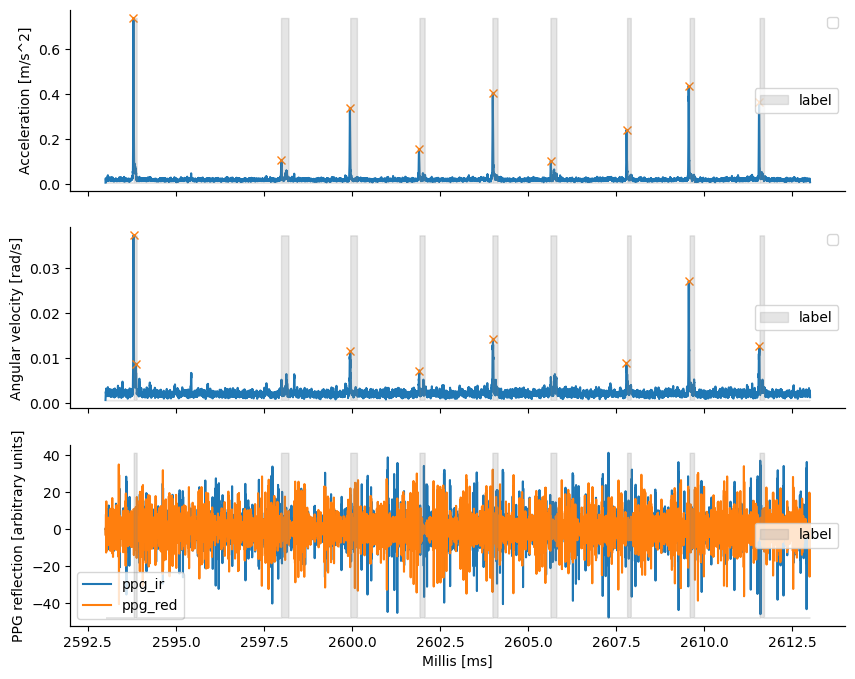

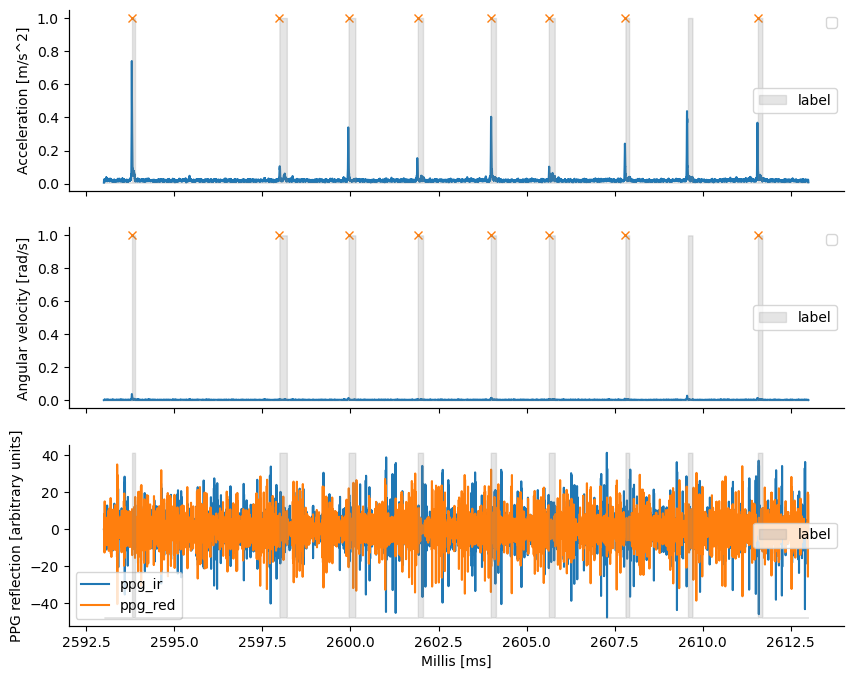

In [25]:
    # setting the cutoff frequencies for highpass filters
    fc_h_acc = 60
    fc_h_gyro = 60
    fc_h_ppg = 60

    # Setting the starting time of the window and its width
    time_start = 2593
    win_len = 20
    window_size = 5
    padding = window_size // 2

    # Selecting the specified window of gyroscope and accelerometer signals from IMU sensor
    window_acc , _ = mask_window (time_start, win_len, imu_millis/1e3 , acc)
    window_gyro , window_imu_millis = mask_window (time_start, win_len, imu_millis/1e3 , gyro)

    # Selecting the specified window of ppg signals from PPG sensor
    window_ppg , window_ppg_millis = mask_window (time_start, win_len, ppg_millis/1e3 , ppg)
    
    # Selecting the specified window of label streams
    window_lbl , window_lbl_millis = mask_window (time_start, win_len, lbl_millis/1e3 , lbl)      

    
    # Filtering accelerometer signals via high pass filter and then applying moving avergae filter
    filtered_acc_x = butter_filter(window_acc[:,0], fc_h_acc, fs_imu, order, filter_type='highpass')
    filtered_acc_y = butter_filter(window_acc[:,1], fc_h_acc, fs_imu, order, filter_type='highpass')
    filtered_acc_z = butter_filter(window_acc[:,2], fc_h_acc, fs_imu, order, filter_type='highpass')
    filtered_acc = np.vstack((filtered_acc_x,filtered_acc_y,filtered_acc_z)).T
    filtered_acc = np.convolve(np.pad(np.sqrt(np.sum(np.square(filtered_acc), axis=1)),padding, mode='edge'), np.ones(window_size)/window_size, mode='valid')

    
    # Applying peak detection algorithm to our processed signal to find the location of strong peaks corresponding to rising edges of the label stream
    peak_finder_setting = {'height': 0.1, 'prominence': None, 'distance_factor': 0.04}
    peaks_acc, _ = fp(
            filtered_acc,
            height=peak_finder_setting['height'],
            prominence=peak_finder_setting['prominence'],
            distance= peak_finder_setting['distance_factor']*fs_imu
    )

    # Filtering gyroscope signals via high pass filter and then applying moving avergae filter
    filtered_gyro_x = butter_filter(window_gyro[:,0], fc_h_gyro, fs_imu, order, filter_type='highpass')
    filtered_gyro_y = butter_filter(window_gyro[:,1], fc_h_gyro, fs_imu, order, filter_type='highpass')
    filtered_gyro_z = butter_filter(window_gyro[:,2], fc_h_gyro, fs_imu, order, filter_type='highpass')
    filtered_gyro = np.vstack((filtered_gyro_x,filtered_gyro_y,filtered_gyro_z)).T
    filtered_gyro = np.convolve(np.pad(np.sqrt(np.sum(np.square(filtered_gyro), axis=1)),padding, mode='edge'), np.ones(window_size)/window_size, mode='valid')

    ## Applying peak detection algorithm to our processed signal to find the location of strong peaks corresponding to rising edges of the label stream
    peak_finder_setting = {'height': 0.007, 'prominence': None, 'distance_factor': 0.04}
    peaks_gyro, _ = fp(
            filtered_gyro,
            height=peak_finder_setting['height'],
            prominence=peak_finder_setting['prominence'],
            distance= peak_finder_setting['distance_factor']*fs_imu
    )


    # Filtering ppg  signals via high pass filter, while they do not contribute to detection
    filtered_ppg_ir = butter_filter(window_ppg[:,0], fc_h_ppg, fs_ppg, order, filter_type='highpass')
    filtered_ppg_red = butter_filter(window_ppg[:,1], fc_h_ppg, fs_ppg, order, filter_type='highpass')
    filtered_ppg = np.vstack((filtered_ppg_ir,filtered_ppg_red)).T


    # Plotting in the presence of peaks found by peak detection algorithm, which also contain peaks that might be far from the rising edges of label stream
    _, axarr_window = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
    #axarr_window[0].plot(window_imu_millis, np.sqrt(np.sum(np.square(filtered_acc), axis=1)))
    axarr_window[0].plot(window_imu_millis, filtered_acc)
    axarr_window[0].plot(window_imu_millis[peaks_acc], filtered_acc[peaks_acc], "x")
    plot_lab_window(axarr_window[0].twinx(), window_lbl_millis, window_lbl)
    
    #axarr_window[1].plot(window_imu_millis,np.sqrt(np.sum(np.square(filtered_gyro), axis=1)))
    axarr_window[1].plot(window_imu_millis, filtered_gyro)
    axarr_window[1].plot(window_imu_millis[peaks_gyro], filtered_gyro[peaks_gyro], "x")
    plot_lab_window(axarr_window[1].twinx(), window_lbl_millis, window_lbl)

    axarr_window[2].plot(window_ppg_millis, filtered_ppg, label=["ppg_ir", "ppg_red"])
    plot_lab_window(axarr_window[2].twinx(), window_lbl_millis, window_lbl)

    for ax in axarr_window:
        ax.spines[["top", "right"]].set_visible(False)
        ax.legend()

    axarr_window[0].set_ylabel("Acceleration [m/s^2]")
    axarr_window[1].set_ylabel("Angular velocity [rad/s]")
    axarr_window[2].set_ylabel("PPG reflection [arbitrary units]")
    axarr_window[2].set_xlabel("Millis [ms]")

    
    # Here, we process our results from peak detection to determine which ones are correctly detecting the rising edge of a label stream

    num_rising_edges, rising_edges_loc  = count_rising_edges(window_lbl) # count the number of rising edges and find their location (indices within the window)
        
    peaks_identified =rising_edges_identification(window_lbl, window_lbl_millis, window_imu_millis, window_gyro, window_acc, peaks_acc, peaks_gyro, 0.02) # number -1 indicates that rising is not identified
    indices_rising_edges_indetified= np.where(peaks_identified!=-1)[0] # which rising edges in label streams are identified, according to their index, the first one starts with number zero
    print("indices of rising edges identified within the window: ", indices_rising_edges_indetified)

    ####
    
                
    # Quality of High Pass Filter

    temp =window_lbl_millis[rising_edges_loc]
    temp2 =window_lbl[rising_edges_loc]
    if num_rising_edges == 0:
        print("\nthere is no rising edge present in the window")
    elif (np.all(peaks_identified == -1)):
        print("\nthere is no rising edge identified")
    else:
        mse_error=np.sqrt(np.sum(np.square(peaks_identified[peaks_identified!=-1]-temp[peaks_identified!=-1]))) # computed over those rising edges which were correctly identified (measuring delay in detection of rising edges)
        accuracy = len(temp[peaks_identified!=-1])/num_rising_edges # ratio of identified rising edges
   
        print("\nMean-Square_Error for the identified rising edges is", mse_error )
        print("accuracy is", accuracy )

    temp =window_lbl_millis[rising_edges_loc]
    temp2 =window_lbl[rising_edges_loc]

    # Plotting in the presence of peaks found by peak detection algorithm, which also contain peaks that might be far from the rising edges of label stream
    _, axarr_window = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
#axarr_window[0].plot(window_imu_millis, np.sqrt(np.sum(np.square(filtered_acc), axis=1)))
    axarr_window[0].plot(window_imu_millis, filtered_acc)
    axarr_window[0].plot(temp[peaks_identified!=-1], temp2[peaks_identified!=-1], "x")
    plot_lab_window(axarr_window[0].twinx(), window_lbl_millis, window_lbl)
    
    #axarr_window[1].plot(window_imu_millis,np.sqrt(np.sum(np.square(filtered_gyro), axis=1)))
    axarr_window[1].plot(window_imu_millis, filtered_gyro)
    axarr_window[1].plot(temp[peaks_identified!=-1], temp2[peaks_identified!=-1], "x")
    plot_lab_window(axarr_window[1].twinx(), window_lbl_millis, window_lbl)

    axarr_window[2].plot(window_ppg_millis, filtered_ppg, label=["ppg_ir", "ppg_red"])
    plot_lab_window(axarr_window[2].twinx(), window_lbl_millis, window_lbl)

    for ax in axarr_window:
        ax.spines[["top", "right"]].set_visible(False)
        ax.legend()

    axarr_window[0].set_ylabel("Acceleration [m/s^2]")
    axarr_window[1].set_ylabel("Angular velocity [rad/s]")
    axarr_window[2].set_ylabel("PPG reflection [arbitrary units]")
    axarr_window[2].set_xlabel("Millis [ms]")





In our evaluation of high pass filter performance in detecting the rising edges of the label stream, we carefully selected two metrics to assess its performance. We focus only on gyroscope and accelerometer as filtered PPG measurements show no clear correlation with the rising edges of label streams.We start by applying a Butterworth highpass filter to gyroscope and accelerometer measurements within the specified window. Here, we opted for larger window to have a better understanding our highpass filter performance. Next, we use a moving average filter with a window size of 5 to smooth the signal. Following this, a peak detection algorithm is applied, which is carefully tuned to avoid capturing weak peaks and closely space peaks. Each identified peaks is now examined to check if it falls within a close proximity of a rising edges (correctly indetified). If so, we consider this peak as a correspondent to a rising edge in the label stream. In cases where multiple peaks correspond to the same rising edge of a label stream, we choose the one with maximum magnitude. 


We then fuse the identification results from gryoscope and acccelerometer data, to rising edges of the label stream. We combine them using OR logic such that if a rising edge is identified by either of the gyroscope or accelerometer measurements, we consider that rising edge as correctly identified, we take the average of timestamps associated with gyroscope and accelremoeter measurements as the timestamp where the rising edge of the label stream occurs. To measuring the quality of our high pass filter, we employ the mean-square-error metric which accounts for the mean-square of delays incurred by the highpass filter in detecting the correctly rising edges within the considered window (computed over those rising edges where our algorithm have been able to successfully identify it). In addition, we compute the ratio of rising edges correctly identified by the highpass filter within the considered window as another metric for assessing the quality of our highpass filter for the considered task. 

As it can be observed the latter plot illustrates the final result of detection of rising edges, the low pass filter failed to detect one of the edges, with an accuracy of 0.88 and MSE of 0.0303.

##  Downsampling

indices of rising edges identified within the window:  [0 4]

Mean-Square_Error for the identified rising edges is 0.02566563441453556
accuracy is 0.2222222222222222


/tmp/ipykernel_28886/1894686821.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


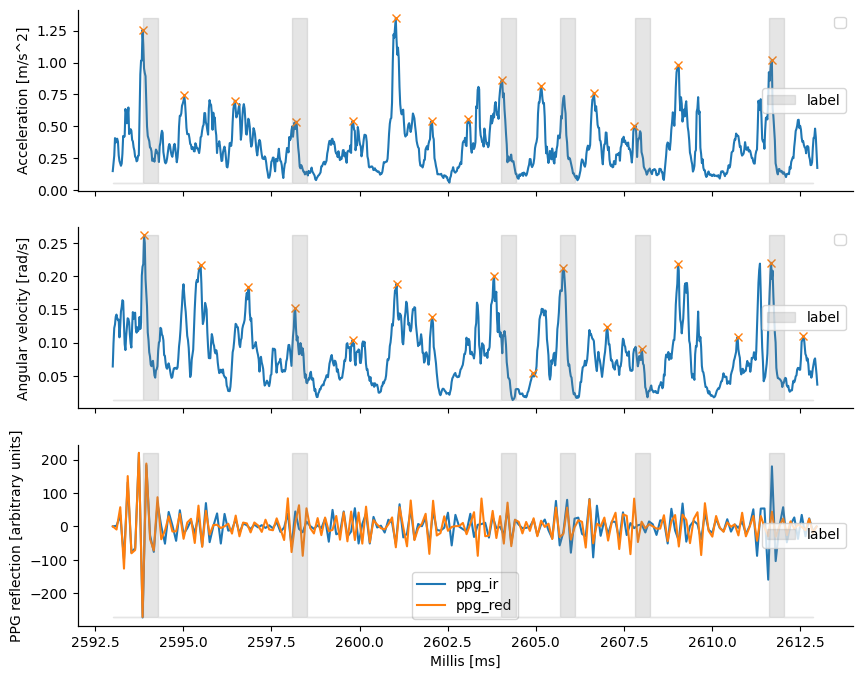

In [26]:

# Setting the starting time of the window and its width
time_start = 2593
win_len = 20
window_size = 5
padding = window_size // 2

# Selecting the specified window of gyroscope and accelerometer signals from IMU sensor
window_acc , _ = mask_window (time_start, win_len, imu_millis/1e3 , acc)
window_gyro , window_imu_millis = mask_window (time_start, win_len, imu_millis/1e3 , gyro)

    # Selecting the specified window of ppg signals from PPG sensor
window_ppg , window_ppg_millis = mask_window (time_start, win_len, ppg_millis/1e3 , ppg)
    
    # Selecting the specified window of label streams
window_lbl , window_lbl_millis = mask_window (time_start, win_len, lbl_millis/1e3 , lbl)  

# Downsample the signals with a factor of 2 
downsample_factor = 20

downsampled_imu_millis=window_imu_millis[::downsample_factor]
downsampled_acc_x=window_acc[::downsample_factor,0]
downsampled_acc_y=window_acc[::downsample_factor,1]
downsampled_acc_z=window_acc[::downsample_factor,2]
downsampled_acc = np.vstack((downsampled_acc_x,downsampled_acc_y,downsampled_acc_z)).T

downsampled_gyro_x = window_gyro[::downsample_factor,0]
downsampled_gyro_y = window_gyro[::downsample_factor,1]
downsampled_gyro_z = window_gyro[::downsample_factor,2]
downsampled_gyro = np.vstack((downsampled_gyro_x,downsampled_gyro_y,downsampled_gyro_z)).T

downsampled_ppg_millis = window_ppg_millis[::downsample_factor]
downsampled_ppg_ir = window_ppg[::downsample_factor,0]
downsampled_ppg_red = window_ppg[::downsample_factor,1]
downsampled_ppg = np.vstack((downsampled_ppg_ir,downsampled_ppg_red)).T


downsampled_lbl_millis=window_lbl_millis[::downsample_factor]
downsampled_lbl=window_lbl[::downsample_factor]



# Filtering accelerometer signals via high pass filter and then applying moving avergae filter
filtered_acc_x = butter_filter(downsampled_acc_x, fc_h_acc, fs_imu, order, filter_type='highpass')
filtered_acc_y = butter_filter(downsampled_acc_y, fc_h_acc, fs_imu, order, filter_type='highpass')
filtered_acc_z = butter_filter(downsampled_acc_z, fc_h_acc, fs_imu, order, filter_type='highpass')
filtered_acc = np.vstack((filtered_acc_x,filtered_acc_y,filtered_acc_z)).T
filtered_acc = np.convolve(np.pad(np.sqrt(np.sum(np.square(filtered_acc), axis=1)),padding, mode='edge'), np.ones(window_size)/window_size, mode='valid')

    
# Applying peak detection algorithm to our processed signal to find the location of strong peaks corresponding to rising edges of the label stream
peak_finder_setting = {'height': 0.5, 'prominence': None, 'distance_factor': 0.04}
peaks_acc, _ = fp(
        filtered_acc,
        height=peak_finder_setting['height'],
        prominence=peak_finder_setting['prominence'],
        distance= peak_finder_setting['distance_factor']*fs_imu
)

# Filtering gyroscope signals via high pass filter and then applying moving avergae filter
filtered_gyro_x = butter_filter(downsampled_gyro_x, fc_h_gyro, fs_imu, order, filter_type='highpass')
filtered_gyro_y = butter_filter(downsampled_gyro_y, fc_h_gyro, fs_imu, order, filter_type='highpass')
filtered_gyro_z = butter_filter(downsampled_gyro_z, fc_h_gyro, fs_imu, order, filter_type='highpass')
filtered_gyro = np.vstack((filtered_gyro_x,filtered_gyro_y,filtered_gyro_z)).T
filtered_gyro = np.convolve(np.pad(np.sqrt(np.sum(np.square(filtered_gyro), axis=1)),padding, mode='edge'), np.ones(window_size)/window_size, mode='valid')

## Applying peak detection algorithm to our processed signal to find the location of strong peaks corresponding to rising edges of the label stream
peak_finder_setting = {'height': 0.04, 'prominence': None, 'distance_factor': 0.04}
peaks_gyro, _ = fp(
        filtered_gyro,
        height=peak_finder_setting['height'],
        prominence=peak_finder_setting['prominence'],
        distance= peak_finder_setting['distance_factor']*fs_imu
)


# Filtering ppg  signals via high pass filter, while they do not contribute to detection
filtered_ppg_ir = butter_filter(downsampled_ppg[:,0], fc_h_ppg, fs_ppg, order, filter_type='highpass')
filtered_ppg_red = butter_filter(downsampled_ppg[:,1], fc_h_ppg, fs_ppg, order, filter_type='highpass')
filtered_ppg = np.vstack((filtered_ppg_ir,filtered_ppg_red)).T

 # Plotting in the presence of peaks found by peak detection algorithm, which also contain peaks that might be far from the rising edges of label stream
_, axarr_window = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
#axarr_window[0].plot(window_imu_millis, np.sqrt(np.sum(np.square(filtered_acc), axis=1)))
axarr_window[0].plot(downsampled_imu_millis, filtered_acc)
axarr_window[0].plot(downsampled_imu_millis[peaks_acc], filtered_acc[peaks_acc], "x")
plot_lab_window(axarr_window[0].twinx(), downsampled_lbl_millis, downsampled_lbl)
    
#axarr_window[1].plot(window_imu_millis,np.sqrt(np.sum(np.square(filtered_gyro), axis=1)))
axarr_window[1].plot(downsampled_imu_millis, filtered_gyro)
axarr_window[1].plot(downsampled_imu_millis[peaks_gyro], filtered_gyro[peaks_gyro], "x")
plot_lab_window(axarr_window[1].twinx(), downsampled_lbl_millis, downsampled_lbl)

axarr_window[2].plot(downsampled_ppg_millis, filtered_ppg, label=["ppg_ir", "ppg_red"])
plot_lab_window(axarr_window[2].twinx(), downsampled_lbl_millis, downsampled_lbl)

for ax in axarr_window:
    ax.spines[["top", "right"]].set_visible(False)
    ax.legend()

axarr_window[0].set_ylabel("Acceleration [m/s^2]")
axarr_window[1].set_ylabel("Angular velocity [rad/s]")
axarr_window[2].set_ylabel("PPG reflection [arbitrary units]")
axarr_window[2].set_xlabel("Millis [ms]")

    
    # Here, we process our results from peak detection to determine which ones are correctly detecting the rising edge of a label stream

num_rising_edges, rising_edges_loc  = count_rising_edges(downsampled_lbl) # count the number of rising edges and find their location (indices within the window)
        
peaks_identified =rising_edges_identification(downsampled_lbl, downsampled_lbl_millis, downsampled_imu_millis, downsampled_gyro, downsampled_acc, peaks_acc, peaks_gyro, 0.02) # number -1 indicates that rising is not identified
indices_rising_edges_identified= np.where(peaks_identified!=-1)[0] # which rising edges in label streams are identified, according to their index, the first one starts with number zero
print("indices of rising edges identified within the window: ", indices_rising_edges_identified)

    ####
    
                
    # Quality of High Pass Filter
num_rising_edges, _  = count_rising_edges(window_lbl)
temp=downsampled_lbl_millis[rising_edges_loc]

if num_rising_edges == 0:
    print("\nthere is no rising edge present in the window")
elif (np.all(peaks_identified == -1)):
    print("\nthere is no rising edge identified")
else:

    mse_error=np.sqrt(np.sum(np.square(peaks_identified[peaks_identified!=-1]-temp[peaks_identified!=-1]))) # computed over those rising edges which were correctly identified (measuring delay in detection of rising edges)
    accuracy = len(temp[peaks_identified!=-1])/num_rising_edges # ratio of identified rising edges
   
    print("\nMean-Square_Error for the identified rising edges is", mse_error )
    print("accuracy is", accuracy )




After downsampling the signal by a factor of 4, we have noticed an increase in the number of undesirable strong peaks within the filtered signal. Such a behavior makes it very difficult to distinguish the strong peaks corresponding to the rising edges of the label stream from these undesirable peaks. In addition, we see that it is crucial to readjust the thresholds used for distinguishing the peaks corresponding to the rising edges of label streams from others, should now be set to larger values to compensate for the amplified noise.

As a result, the detection of rising edges now decreases to 0.44 percent. Downsampling introduces additional issues, as it leads to even complete omission of some of the rising edges. When using downsampling factors above 20, the effectiveness of the high pass filter decreases substantially. The distinct peaks corresponding to the rising edges of the label stream become indistinguishable from other peaks, which makes the identification of relevant information impractical.